# Usage of py-ciu

This notebook is included for the purpose of illustrating the use of the CIU method and how to use the py-ciu package. The notebook is also used for ensuring that all examples execute correctly (similarly to the "R" version of CIU, where the entire README is generated by R Studio). 

In [1]:
# Execute this for running the package as cloned source code from Github. 
# Then your working directory should be the downloaded package directory (py-ciu). For installing the 
# package as "editable", do '!pip install -e .' instead:
#!pip install .
# For checking the version (and get other information), do 
#!pip3 show py-ciu

## Minimal use example

First import the library. 

In [2]:
# If everything is set up correctly, then this should execute fine.
import ciu as ciu

In order to keep these examples short, we import some helper/testing functions that import data, train a model and provide a test instance. We start with the well-known Titanic use case and produce a "overlap" CIU visualisation, where CI is shown by the length of the transparent bar, whereas the utility is indicated by the solid bar. CU=0 gives no bar, CU=1 gives a solid bar that covers the transparent bar entirely. In addition to feature importance and value utility, this plot also gives a kind of "What if?" explanation because it indicates what changes in input values would modify the outcome the most. 

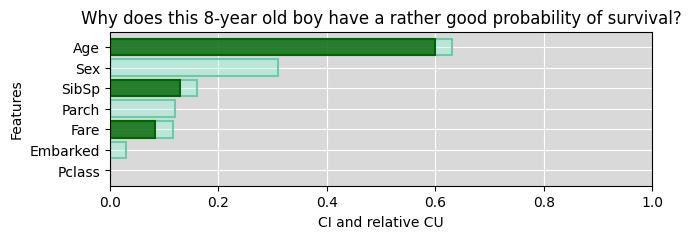

In [3]:
import numpy as np
from ciu_tests import titanic_rf

np.random.seed(26)
CIU_titanic, titanic_model, titanic_instance = titanic_rf.get_titanic_rf()
CIU_titanic.explain(titanic_instance, output_inds=1)
CIU_titanic.plot_ciu(plot_mode='overlap', main="Why does this 8-year old boy have a rather good probability of survival?", figsize=(7,2))

We can also visualize the Contextual influence, which is more familiar to LIME/SHAP/etc users. Influence values are always relative to some baseline/reference value. Here we use the default "neutralCU=0.5" value. 

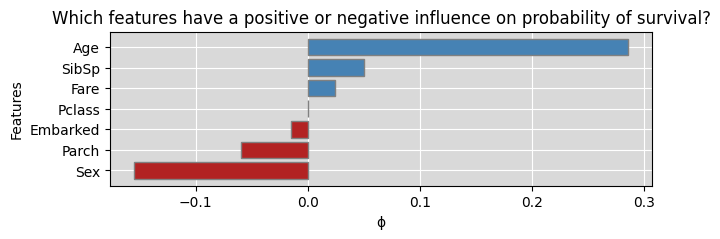

In [4]:
CIU_titanic.plot_influence(main="Which features have a positive or negative influence on probability of survival?", figsize=(7,2))

## Digging deeper into CIU capabilities

The rest of this notebook showcases various capabilities of CIU for different data sets. We begin with a simple example using the well known Iris flower dataset:

In [5]:
import pandas as pd
import matplotlib.pylab as py_plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.random.seed(26)
iris=datasets.load_iris()

df = pd.DataFrame(data = np.c_[iris['data'], iris['target']],
              columns = iris['feature_names'] + ['target'])
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)
df.columns = ['s_length', 's_width', 'p_length', 'p_width', 'target', 'species']
iris_outnames = df['species'].cat.categories.tolist()
X = df[['s_length', 's_width', 'p_length', 'p_width']]
y = df['species']
np.random.seed(8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

Then create and train a model, in this case an `LDA` model

In [6]:
model = LinearDiscriminantAnalysis()
model.fit(X_train, y_train)

LinearDiscriminantAnalysis()

We choose an instance from the test set to explain.

In [7]:
inst_ind = 42
instance = X_test.iloc[[inst_ind]]
inst_class = y_test.iloc[inst_ind]
pred = model.predict(instance)[0]
print(f"Instance {inst_ind} in the test set is a {inst_class} and it is predicted to be a {pred}")
print(f"The instance values are:\n{instance}")

Instance 42 in the test set is a virginica and it is predicted to be a virginica
The instance values are:
     s_length  s_width  p_length  p_width
143       6.8      3.2       5.9      2.3


Then get CIU values for this instance. The ``explain`` method returns a DataFrame with all relevant values from CIU calculations. 

In [8]:
iris_ciu = ciu.CIU(model.predict_proba, iris_outnames, data=X_train)
CIUres = iris_ciu.explain(instance, output_inds=2)
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
s_length,0.000074,0.953773,0.000034,virginica,0.999997,s_length,9.999257e-01,1.0,[0],[6.8],0.5,None,None
s_width,0.000237,0.985937,0.000115,virginica,0.999997,s_width,9.997626e-01,1.0,[1],[3.2],0.5,None,None
p_length,1.000000,0.999997,0.499997,virginica,0.999997,p_length,6.464905e-19,1.0,[2],[5.9],0.5,None,None
p_width,1.000000,0.999997,0.499997,virginica,0.999997,p_width,4.378181e-08,1.0,[3],[2.3],0.5,None,None


This was a **"Why?"** explanation, where we can see that Petal length and Petal width are the most(/only) relevant features with CI=1. This instance is a very typical Virginica, as shown by the close-to-one CU values for all features. 

We can also plot this explanation but it's now very interesting in the case of Iris:

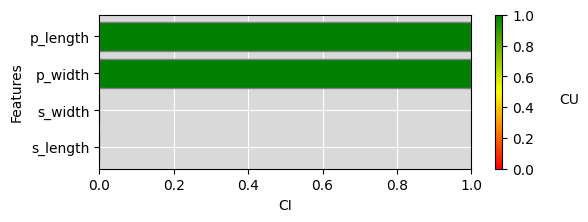

In [9]:
iris_ciu.plot_ciu(CIUres, figsize=(6,2))

We can also get a **"Why not?"** explanation for "Why not a Versicolor?":

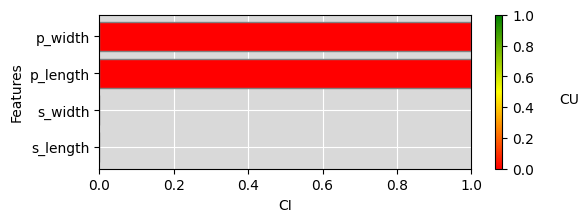

In [10]:
CIUres_versicolor = iris_ciu.explain(instance, output_inds=1)
iris_ciu.plot_ciu(CIUres_versicolor, figsize=(6,2))

The CIU plotting methods use the result from the last call to `explain` or `explain_voc` by default, so this can also be done without providing the CIU result explicitly:

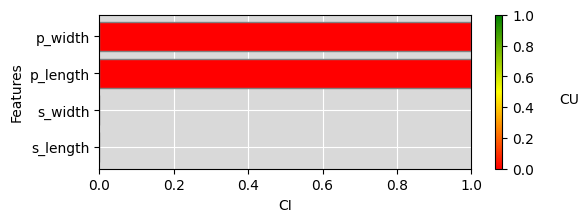

In [11]:
iris_ciu.plot_ciu(figsize=(6,2))

We see that Petal length and Petal width are also here the most(/only) relevant features with CI~=1. However, the CU values are almost zero so this is definitely not a Versicolor. 

## Boston Housing example

We start by getting the Boston data and preparing it:

In [18]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep=r"\s+", skiprows=22, header=None)
data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
target = raw_df.values[1::2, 2]

data = pd.DataFrame(data)
data.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

Then train an XGB model for predicting Boston house prices based on the data set:

In [19]:
import xgboost as xgb

np.random.seed(26)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

We choose an expensive instance from the test set to explain:

In [20]:
inst_ind = np.argmax(xg_reg.predict(X_test)) # Test set instance with highest price estimate, so we expect a "positive" explanation.
instance = X_test.iloc[[inst_ind]]
inst_val = y_test[inst_ind]
pred = xg_reg.predict(instance)[0]
print(f"Instance {inst_ind} in the test set has a real price of ${inst_val:.0f} and a predicted price of ${pred:.0f}")
print(f"The instance values are:\n{instance}")

Instance 17 in the test set has a real price of $43 and a predicted price of $34
The instance values are:
        CRIM    ZN  INDUS  CHAS    NOX    RM   AGE     DIS  RAD    TAX  \
261  0.53412  20.0   3.97   0.0  0.647  7.52  89.4  2.1398  5.0  264.0   

     PTRATIO       B  LSTAT  
261     13.0  388.37   7.26  


We need to know the minimal and maximal price values in order to know how cheap or expensive the instance is:

In [21]:
out_minmaxs = pd.DataFrame({'mins': [min(y_train)], 'maxs': max(y_train)})
print(f"The minimal price in the training set is ${min(y_train):.0f} and the maximal price is ${max(y_train):.0f}")

The minimal price in the training set is $5 and the maximal price is $50


Then get CIU Object and show tabular results:

In [22]:
boston_ciu = ciu.CIU(xg_reg.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs)
CIUres = boston_ciu.explain(instance)
display(CIUres)

,CI,CU,Cinfl,outname,outval,feature,ymin,ymax,inputs,invals,neutralCU,target_concept,target_inputs
CRIM,0.056011,1.000000,0.028006,Price,34.023457,CRIM,31.502943,34.023457,[0],[0.53412],0.5,None,None
ZN,0.009911,1.000000,0.004956,Price,34.023457,ZN,33.577450,34.023457,[1],[20.0],0.5,None,None
INDUS,0.057076,1.000000,0.028538,Price,34.023457,INDUS,31.455057,34.023457,[2],[3.97],0.5,None,None
CHAS,0.000000,0.000000,-0.000000,Price,34.023457,CHAS,34.023457,34.023457,[3],[0.0],0.5,None,None
NOX,0.048834,1.000000,0.024417,Price,34.023457,NOX,31.825907,34.023457,[4],[0.647],0.5,None,None
RM,0.074986,1.000000,0.037493,Price,34.023457,RM,30.649109,34.023457,[5],[7.52],0.5,None,None
AGE,0.046000,1.000000,0.023000,Price,34.023457,AGE,31.953468,34.023457,[6],[89.4],0.5,None,None
DIS,0.051620,0.904325,0.020871,Price,34.023457,DIS,31.922781,34.245701,[7],[2.1398],0.5,None,None
RAD,0.000000,0.000000,-0.000000,Price,34.023457,RAD,34.023457,34.023457,[8],[5.0],0.5,None,None
TAX,0.043273,1.000000,0.021636,Price,34.023457,TAX,32.076191,34.023457,[9],[264.0],0.5,None,None


Now we can also plot the CI/CU values using the CIU Object's ``plot_ciu`` function. Due to the relatively small CI values, we reduce the extent of the X-axis for readability.

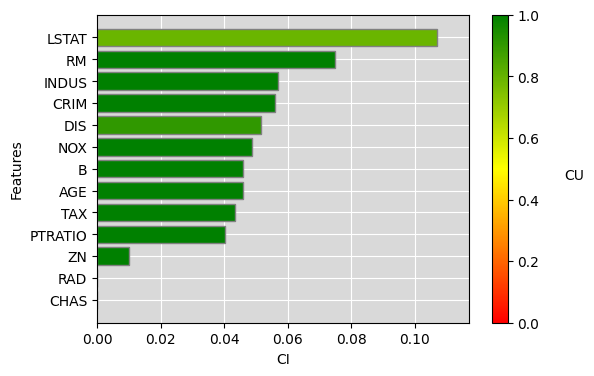

In [23]:
boston_ciu.plot_ciu(CIUres, CImax=min(1.0,(max(CIUres.CI)+0.01)))

There are several plot options available using the following parameters, such as:

* ``plot_mode``: defines the type plot to use between 'color_CU', 'overlap' and 'combined'.                                                 
* ``sort``: defines the order of the plot bars by the 'ci' (default), 'cu' values or unsorted if None.
* ``color_blind``: defines accessible color maps to use for the plots, such as 'protanopia', 'deuteranopia' and 'tritanopia'.                           
* ``color_edge_cu``: defines the hex or named color for the CU edge in the overlap plot mode.         
* ``color_fill_cu``: defines the hex or named color for the CU fill in the overlap plot mode.         
* ``color_edge_ci``: defines the hex or named color for the CI edge in the overlap plot mode.         
* ``color_fill_ci``: defines the hex or named color for the CI fill in the overlap plot mode.         

Here's an example using some of these parameters to create a modified version of the above plot 

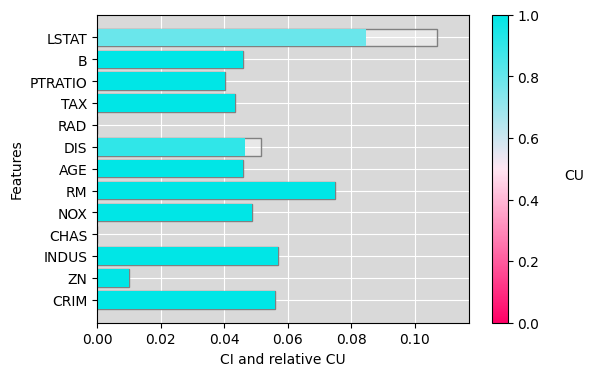

In [24]:
boston_ciu.plot_ciu(CIUres, plot_mode="combined", color_blind='tritanopia', sort='cu', CImax=min(1.0,(max(CIUres.CI)+0.01)))

## Contextual influence

Contextual influence is calculated from CI and CU as follows:

$$
\phi_{j,\{i\},\{I\}}(x)=\omega_{j,\{i\},\{I\}}(x)(CU_{j,\{i\}}(x) - \phi_{0}),
$$

where $\phi_{0}$ is the *baseline/reference* value ($y(u(0))$ in the
plot). For instance, $\phi_{0}=0.5$ signifies using the average utility
value $0.5$ as the baseline.
An explanation using Contextual influence on the titanic dataset can be obtained as follows:

*Note*: the dataset and model used are not identical to the R version, 
therefore the results will see a slight variance. 

In [25]:
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv("https://raw.githubusercontent.com/KaryFramling/py-ciu/master/ciu_tests/data/titanic.csv")
data = data.drop(data.columns[0], axis=1)
unused = ['PassengerId','Cabin','Name','Ticket']

for col in unused:
    data = data.drop(col, axis=1)

np.random.seed(26)
from sklearn.preprocessing import LabelEncoder
data = data.dropna().apply(LabelEncoder().fit_transform)
train = data.drop('Survived', axis=1)

model = RandomForestClassifier(n_estimators=100)
model.fit(train, data.Survived)

RandomForestClassifier()

Create a new instance to explain (the 8-year old boy used in te book https://ema.drwhy.ai):

In [26]:
# Create test instance (8-year old boy)
new_passenger = pd.DataFrame.from_dict({"Pclass" : [1], "Sex": [1], "Age": [8], "SibSp": [0], "Parch": [0], "Fare": [72], "Embarked": [2]})

Let's check out some basic things about the instance:

In [27]:
surv_prob = model.predict_proba(new_passenger)
print(f"The estimated probability of survival is {surv_prob[0,1]:.2f}.")
titanic_train_probs = model.predict_proba(train)
print(titanic_train_probs.shape)
mean_surv_prob = np.mean(titanic_train_probs[:,1])
print(f"The mean probability of survival in the training set is {mean_surv_prob:.2f}.")

The estimated probability of survival is 0.61.
(712, 2)
The mean probability of survival in the training set is 0.41.


If we want to make a distinction between numerical (floating point) features and integer/symbolic features, then we need to tell CIU what to use as integer/symbolic values using a "category mapping" dictionary. If the values are strings, then they are replaced with the corresponding index for passing to the model. If the values are integers, they are used as such as input values to the model. 

It is important to make this distinction between features also because the perturbation strategy used by CIU depends on it. If no mapping is provided, then all features will be perturbed using random float values within the given min-max range of each feature. 

*Remark*: This is not needed in "R" because ML models and (correctly implemented) XAI methods know how to use the "factor" type for this purpose. 

In [28]:
category_mapping = {
    'Sex': ['female','male'],
    'Pclass': list(range(max(data.Pclass))),
    'SibSp': list(range(max(data.SibSp))),
    'Parch': list(range(max(data.Parch))),
    'Embarked': ["Belfast","Cherbourg","Queenstown","Southampton"]
}

We use the mean probability of survival as the `normalCU` value of Contextual influence for consistency with the SHAP example further down. Here we show a bar chart using Contextual Influence:

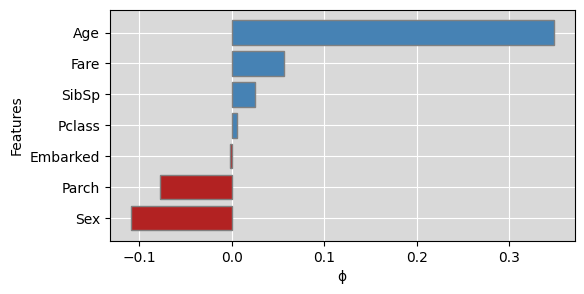

In [29]:
CIU_titanic = ciu.CIU(model.predict_proba, ['No', 'Yes'], data=train, category_mapping=category_mapping)
CIUres = CIU_titanic.explain(new_passenger, output_inds=1, neutralCU=mean_surv_prob)
CIU_titanic.plot_influence(CIUres, figsize=(6,3))

**Remark:** The Equation for Contextual influence is similar to the
definition of Shapley values for linear models, except that the input
value $x_{i}$ is replaced by its utility value(s) $CU_{j,\{i\}}(x)$. In
practice, **all *Additive Feature Attribution (AFA)* methods estimate
influence values, not feature importance. Most state-of-the-art methods
such as *Shapley values*, *LIME*,** are AFA methods.

Influence values give no counter-factual information and are easily
misinterpreted. Below, we create a Shapley value explanation using the
shap package. In that explanation, for instance the close-to-zero Shapley
value for $Parch$ gives the impression that it’s a non-important
feature, which is clearly wrong based on the CIU explanation.

In [30]:
# # Uncomment this if you have shap installed and want to run it. At the moment of writing, shap doesn't work with Python 3.12.
# import shap
# explainer = shap.Explainer(model, train)
# shap_values = explainer(new_passenger)
# shap.plots.bar(shap_values[0,:,1], order=np.argsort(shap_values[0,:,1].values)[::-1])

## Intermediate Concepts

CIU can use named feature coalitions and structured vocabularies. 
Such vocabularies allow explanations at any abstraction level and can make explanations interactive.

The following code snippet plots the joint effect of features $age$ and
$parch$ for the studied Titanic case (applicable for numeric features).
It therefore shows how the coalition of those two features affects the
output value and how CI and CU can be deduced in the same way as for a
single feature.

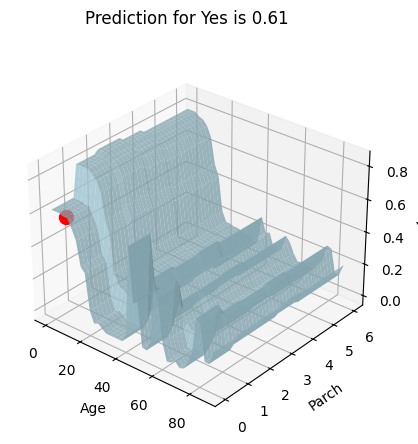

In [31]:
CIU_titanic.plot_3D(ind_inputs=[2,4], ind_output=1, azim=-50)

### Titanic Example

We define a small vocabulary for Titanic as follows:

In [32]:
titanic_voc = {
    "Wealth":['Pclass', 'Fare'],
    "Family":['SibSp', 'Parch'],
    "Gender":['Sex'],
    "Age":['Age'],
    "Embarked":['Embarked']
}
CIU_titanic.vocabulary = titanic_voc

First barplot explanation:

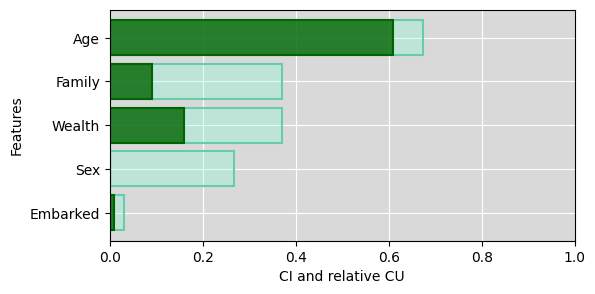

In [33]:
top_res = CIU_titanic.explain_voc(new_passenger, output_inds=1, nsamples=1000)
CIU_titanic.plot_ciu(top_res, plot_mode='overlap', figsize=(6,3))

Then explain FAMILY and WEALTH

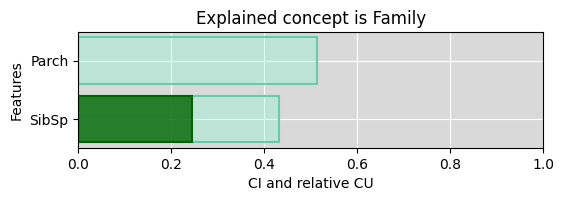

In [34]:
res = CIU_titanic.explain(new_passenger, output_inds=1, target_concept="Family", target_ciu=top_res, nsamples=1000)
CIU_titanic.plot_ciu(res, figsize=(6,1.5), main="Explained concept is Family", plot_mode="overlap")

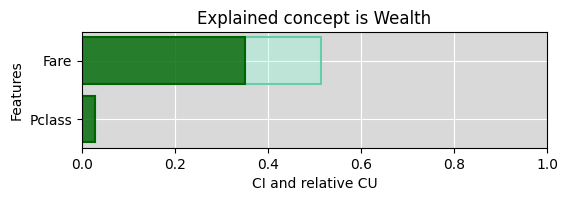

In [35]:
res = CIU_titanic.explain(new_passenger, output_inds=1, target_concept="Wealth", target_ciu=top_res, nsamples=1000)
CIU_titanic.plot_ciu(res, figsize=(6,1.5), main="Explained concept is Wealth", plot_mode="overlap")

Same thing using textual explanations:

In [36]:
print(CIU_titanic.textual_explanation(top_res))

The explained value is Yes with the value 0.61 (CU=0.61), which is higher than average utility.
Feature Wealth has low importance (CI=0.37) and has value(s) [ 1 72], which is lower than average utility (CU=0.43)
Feature Family has low importance (CI=0.37) and has value(s) [0 0], which is low utility (CU=0.24)
Feature Sex has low importance (CI=0.27) and has value(s) 1, which is low utility (CU=0.00)
Feature Age has high importance (CI=0.67) and has value(s) 8, which is high utility (CU=0.91)
Feature Embarked has very low importance (CI=0.03) and has value(s) 2, which is lower than average utility (CU=0.33)



In [37]:
print(CIU_titanic.textual_explanation(res))

The explained value is Wealth for output Yes.
Feature Pclass has very low importance (CI=0.03) and has value(s) 1, which is high utility (CU=1.00)
Feature Fare has normal importance (CI=0.51) and has value(s) 72, which is higher than average utility (CU=0.68)



## Ames Housing Example

Ames housing is a data set about properties in the town Ames in the US. It contains over 80 features that can be used for learning to estimate the sales price. The following code imports the data set (make sure that you have the path to the CSV file set correctly!), does some pre-processing and trains a Gradient Boosting model:

In [38]:
df = pd.read_csv('ciu_tests/data/AmesHousing.csv')

#Checking for missing data
missing_data_count = df.isnull().sum()
missing_data_percent = df.isnull().sum() / len(df) * 100

missing_data = pd.DataFrame({
    'Count': missing_data_count,
    'Percent': missing_data_percent
})

missing_data = missing_data[missing_data.Count > 0]
missing_data.sort_values(by='Count', ascending=False, inplace=True)

#This one has spaces for some reason
df.columns = df.columns.str.replace(' ', '')


#Taking care of missing values
from sklearn.impute import SimpleImputer
# Group 1:
group_1 = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType',
    'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond',
    'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType'
]
df[group_1] = df[group_1].fillna("None")

# Group 2:
group_2 = [
    'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF',
    'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea'
]

df[group_2] = df[group_2].fillna(0)

# Group 3:
group_3a = [
    'Functional', 'MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st',
    'Exterior2nd', 'SaleType', 'Utilities'
]

imputer = SimpleImputer(strategy='most_frequent')
df[group_3a] = pd.DataFrame(imputer.fit_transform(df[group_3a]), index=df.index)

df.LotFrontage = df.LotFrontage.fillna(df.LotFrontage.mean())
df.GarageYrBlt = df.GarageYrBlt.fillna(df.YearBuilt)

#Label encoding
from sklearn.preprocessing import LabelEncoder
df = df.apply(LabelEncoder().fit_transform)

data = df.drop(columns=['SalePrice'])
target = df.SalePrice

#Splitting and training
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=123)
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.5, learning_rate = 0.1, max_depth = 15, alpha = 10)

xg_reg.fit(X_train,y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.5, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=15, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, ...)

We start with an “explanation” using all 80 basic features, which is not very readable and overly detailed for “ordinary” humans to understand:

The minimal price in the training set is $0 and the maximal price is $1031


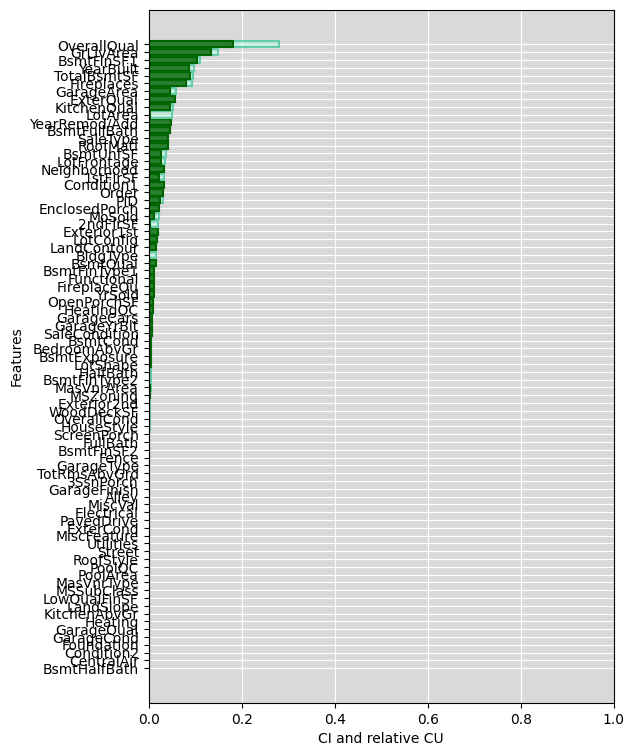

In [39]:
ames_instance = X_test.iloc[[345]]

out_minmaxs = pd.DataFrame({'mins': [min(y_train)], 'maxs': max(y_train)})
print(f"The minimal price in the training set is ${min(y_train):.0f} and the maximal price is ${max(y_train):.0f}")

CIU_ames = ciu.CIU(xg_reg.predict, ['Price'], data=X_train, out_minmaxs=out_minmaxs) #, category_mapping=category_mapping)
CIUres = CIU_ames.explain(ames_instance)
CIU_ames.plot_ciu(CIUres, plot_mode='overlap', figsize=(6,9))

Then we create our vocabulary of intermediate concepts, in this case a list containing dictionaries of a `concept->[columns]` structure as follows:

In [40]:
ames_voc = {
    "Garage":[c for c in df.columns if 'Garage' in c],
    "Basement":[c for c in df.columns if 'Bsmt' in c],
    "Lot":list(df.columns[[3,4,7,8,9,10,11]]),
    "Access":list(df.columns[[13,14]]),
    "House_type":list(df.columns[[1,15,16,21]]),
    "House_aesthetics":list(df.columns[[22,23,24,25,26]]),
    "House_condition":list(df.columns[[20,18,21,28,19,29]]),
    "First_floor_surface":list(df.columns[[43]]),
    "Above_ground_living area":[c for c in df.columns if 'GrLivArea' in c]
}
CIU_ames.vocabulary = ames_voc

Then the same, using highest-level concepts:

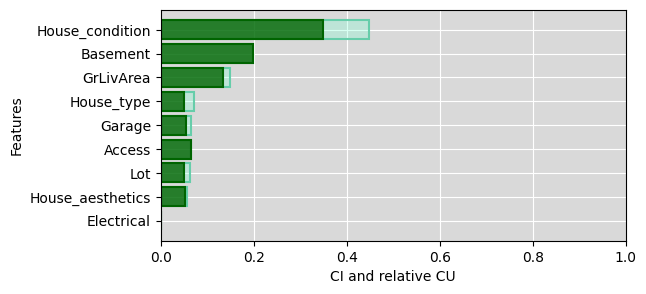

In [41]:
top_res = CIU_ames.explain_voc(ames_instance, nsamples=1000)
CIU_ames.plot_ciu(top_res, figsize=(6,3), plot_mode='overlap')

Then explain further some intermediate concepts:

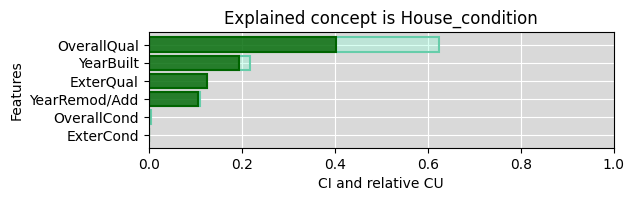

In [42]:
tconcept = "House_condition"
res = CIU_ames.explain(ames_instance, nsamples=1000, target_concept=tconcept, target_ciu=top_res)
CIU_ames.plot_ciu(res, plot_mode="overlap", figsize=(6,1.5), main=f"Explained concept is {tconcept}")

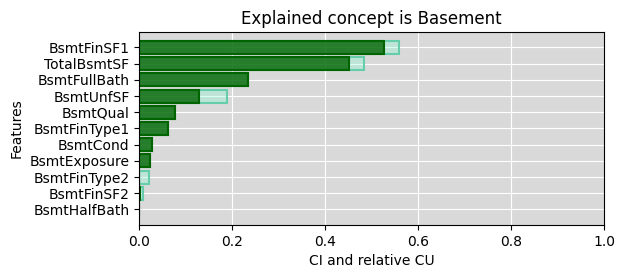

In [43]:
tconcept = "Basement"
res = CIU_ames.explain(ames_instance, target_concept=tconcept, target_ciu=top_res, nsamples=1000)
CIU_ames.plot_ciu(res, plot_mode="overlap", figsize=(6,2.5), main=f"Explained concept is {tconcept}")

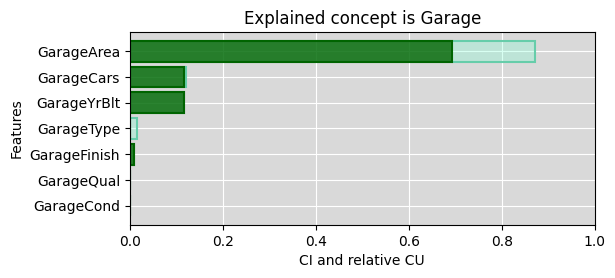

In [44]:
tconcept = "Garage"
res = CIU_ames.explain(ames_instance, target_concept=tconcept, target_ciu=top_res, nsamples=1000)
CIU_ames.plot_ciu(res, plot_mode="overlap", figsize=(6,2.5), main=f"Explained concept is {tconcept}")

This vocabulary is just an example of what kind of concepts a human typically deals with. Vocabularies can be built freely (or learned, if possible) and used freely, even so that different vocabularies can be used with different users.